In [1]:
# Allow Python to find our own project modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import util.util as util

sns.set() # Sets up Seaborn default styles

## Data Import + Additional Columns

In [3]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('../data/covid_lies.csv')
# CovidLies without links, emojis, @Username
clean_df = pd.read_csv('../data/covid_lies_data.csv')
# DF of unique tweets and whether each one advances a misconception
clean_unique = util.transform(clean_df)
unique_tweets = util.transform(df)

In [4]:
# Indicate whether a tweet contains a link
df['contains_link'] = df.tweet.str.contains('https://')
unique_tweets['contains_link'] = unique_tweets.tweet.str.contains('https://')

# Count the number of characters in each tweet
clean_df['tweet_len'] = clean_df.tweet.apply(lambda tweet: len(tweet.split()))
clean_unique['tweet_len'] = clean_unique.tweet.apply(lambda tweet: len(tweet.split()))

In [5]:
# Keys are misconception IDs, values are the misconception in English
misonception_map = pd.Series(df.misconception.values, index = df.misconception_id).to_dict()

## Segmented DataFrames

In [6]:
# Dataframe of (tweet, misconception) pairs that either agree with (pos), reject (neg), or take no stance (na) towards the misconception
pos = df[df.label == 'pos']
neg = df[df.label == 'neg']
na = df[df.label == 'na']
# Prints number of rows in each dataframe
df.label.value_counts()

na     6149
pos     288
neg     154
Name: label, dtype: int64

In [7]:
# Counts the number of times a tweet appears in a (tweet, misconception) pair
sorted_tweet_ids  = df.groupby('tweet_id').tweet.count().sort_values(ascending = False)
print(f"There are {len(sorted_tweet_ids)} unique tweets")

There are 4371 unique tweets


### Stances by Misconception

<AxesSubplot:xlabel='misconception_id', ylabel='count'>

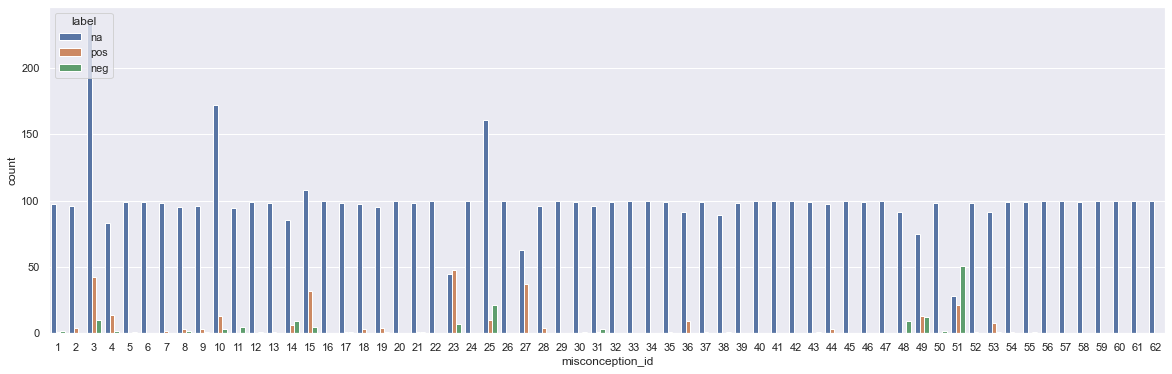

In [8]:
# Sets the size of the figure to be wider
plt.figure(figsize = (20, 6))
sns.countplot(x = 'misconception_id', data = df, hue = 'label')

C:\Users\whou1\anaconda3\envs\uciml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Most Misconceptions Do Not Have Many Tweets Taking a Stance Towards Them'),
 Text(0.5, 0, 'Proportion of tweets taking a stance')]

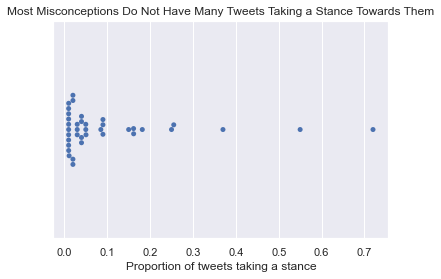

In [9]:
by_misconception = pd.DataFrame(df.groupby('misconception_id').label.value_counts(normalize = True).rename('prop')).reset_index()
# The proportion of tweets taking a stance towards the misconception
prop_by_mid = by_misconception[by_misconception.label.isin(['pos' ,'neg'])].groupby('misconception_id').prop.sum().sort_values(ascending = False)

plot = sns.swarmplot(prop_by_mid)
plot.set(title = 'Most Misconceptions Do Not Have Many Tweets Taking a Stance Towards Them', 
         xlabel = 'Proportion of tweets taking a stance')

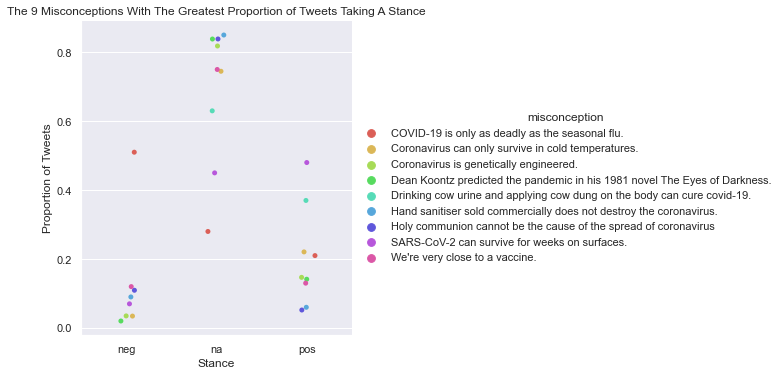

In [10]:
# 9 Misconceptions That Have the Highest Proportion of Tweets Taking a Stance Towards Them
target_misconceptions = target_misconceptions = set(prop_by_mid.index[0:9])
# Prop. Tweets Na/Pos/Neg for The Top 9 Misconceptions
labels_by_top_9_misconceptions = pd.DataFrame(df[df.misconception_id.isin(target_misconceptions)].groupby('misconception').label.value_counts(normalize = True).rename('prop')).reset_index()

plot = sns.catplot(x="label", y="prop", hue="misconception", data=labels_by_top_9_misconceptions, palette='hls')
plot.set(title = 'The 9 Misconceptions With The Greatest Proportion of Tweets Taking A Stance',
         xlabel = 'Stance', ylabel='Proportion of Tweets')

## WordClouds

In [11]:
stopwords = set(STOPWORDS) # Default stopwords from package
stopwords.update(['coronavirus', 'virus', 'pandemic', 'outbreak', 'people', 'CORONAVIRUS', 'covid', 'COVID', 'COVID19', 'CORONA',
                  'https', 'COVID19' 'USERNAME USERNAME', 'USERNAME',
                  'many', 'will', 'still', 'presently', 'co'])

cloud = WordCloud(stopwords=stopwords, min_word_length=2)

#### Common Words Across All Tweets

(-0.5, 399.5, 199.5, -0.5)

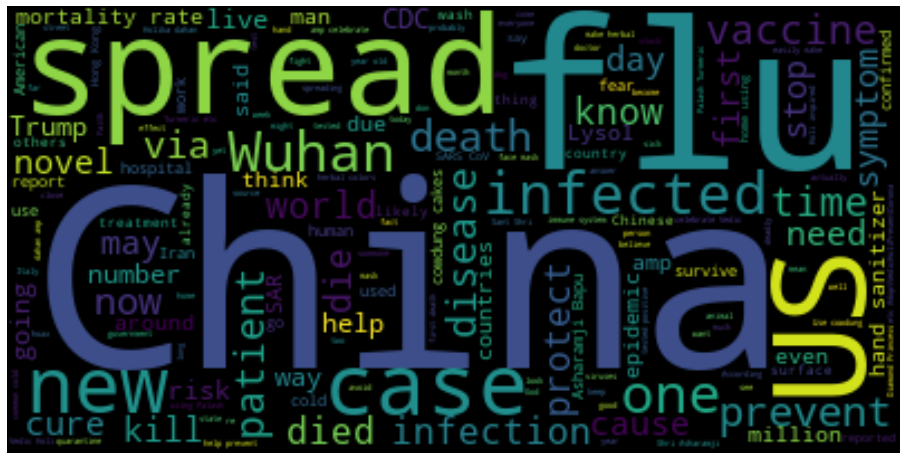

In [12]:
all_tweet_text = " ".join(tweet for tweet in clean_df.tweet)

all_tweet_cloud = cloud.generate(all_tweet_text)

plt.figure(figsize = (16, 12))
plt.imshow(all_tweet_cloud, interpolation='bilinear')
plt.axis("off")

#### Common Words Across Tweets Spreading Misconceptions

(-0.5, 399.5, 199.5, -0.5)

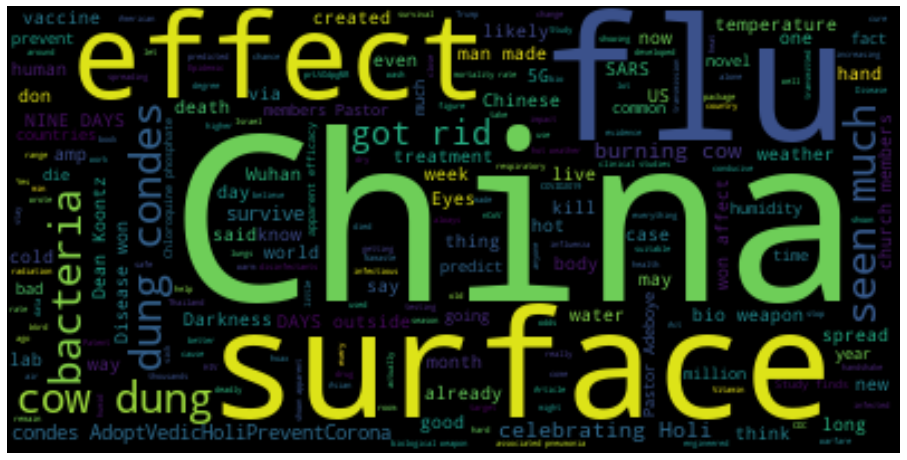

In [13]:
misconception_tweets = " ".join(tweet for tweet in pos.tweet)

misconception_cloud = cloud.generate(misconception_tweets)

plt.figure(figsize = (16, 12))
plt.imshow(misconception_cloud, interpolation='bilinear')
plt.axis("off")

#### Common Words Across Tweets Rejecting Misconceptions

(-0.5, 399.5, 199.5, -0.5)

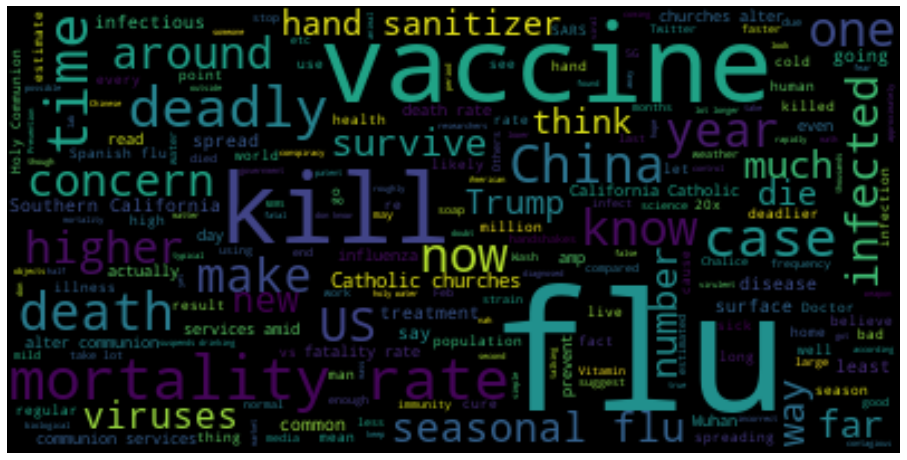

In [14]:
truth_tweets = " ".join(tweet for tweet in neg.tweet)

truth_cloud = cloud.generate(truth_tweets)

plt.figure(figsize = (16, 12))
plt.imshow(truth_cloud, interpolation='bilinear')
plt.axis("off")

#### Common Words Across Tweets Taking No Stance

(-0.5, 399.5, 199.5, -0.5)

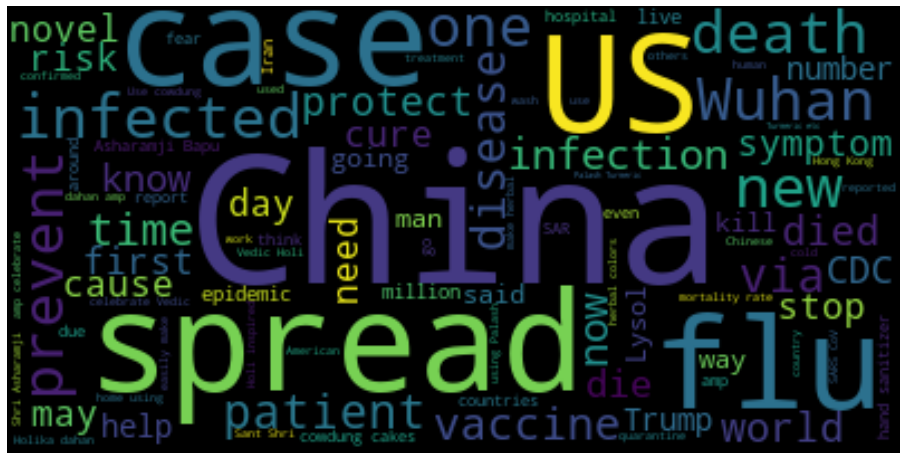

In [15]:
no_stance_tweets = " ".join(tweet for tweet in na.tweet)

no_stance_cloud = cloud.generate(no_stance_tweets)

plt.figure(figsize = (16, 12))
plt.imshow(no_stance_cloud, interpolation='bilinear')
plt.axis("off")

### 

## Link Frequency

#### For Tweet, Misconception Pairs

[Text(0.5, 1.0, 'Tweets Rejecting Misconceptions Are Less Likely to Contain Links'),
 Text(0, 0.5, 'Proportion of tweets containing a link'),
 Text(0.5, 0, 'Position towards misconception')]

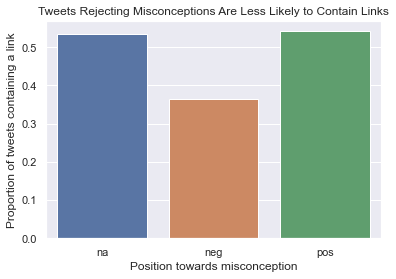

In [16]:
link_frequency_by_label = pd.DataFrame(df.groupby('label').contains_link.value_counts(normalize = True).rename('prop')).reset_index()
# Only get proportions for tweets containing links
contains_link = link_frequency_by_label[link_frequency_by_label.contains_link == True]

link_freq_plot = sns.barplot(x = 'label', y = 'prop', data = contains_link)
link_freq_plot.set(title = 'Tweets Rejecting Misconceptions Are Less Likely to Contain Links', 
                   ylabel = 'Proportion of tweets containing a link', xlabel = 'Position towards misconception')

#### Across Unqiue Tweets 

[Text(0.5, 1.0, 'Tweets That Spread a Misconception Are Still More Likely to Contain a Link, But Only Slightly'),
 Text(0, 0.5, 'Proportion of tweets containing a link'),
 Text(0.5, 0, 'Spreads Misconception')]

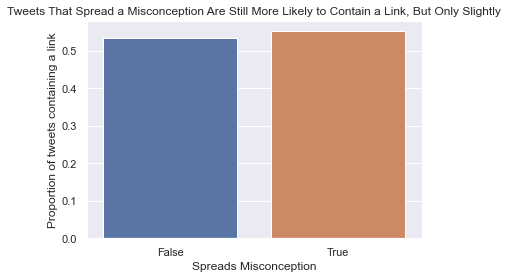

In [17]:
link_frequency_by_label = pd.DataFrame(unique_tweets.groupby('misconception').contains_link.value_counts(normalize = True).rename('prop')).reset_index()
contains_link = link_frequency_by_label[link_frequency_by_label.contains_link == True]

link_freq_plot = sns.barplot(x = 'misconception', y = 'prop', data = contains_link)
link_freq_plot.set(title = 'Tweets That Spread a Misconception Are Still More Likely to Contain a Link, But Only Slightly', 
                   ylabel = 'Proportion of tweets containing a link', xlabel = 'Spreads Misconception')

## Tweet Lengths

#### For Tweet, Misconception Pairs


<AxesSubplot:xlabel='label', ylabel='mean_length'>

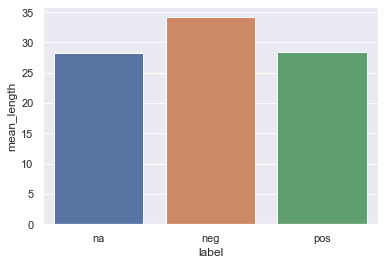

In [18]:
length_by_label = pd.DataFrame(clean_df.groupby('label').tweet_len.mean().rename('mean_length')).reset_index()

sns.barplot(x='label', y='mean_length', data =length_by_label)

#### Across Unique Tweets

[Text(0.5, 1.0, 'Tweets That Spread a Misconception Do Not Have More Words, On Avg'),
 Text(0.5, 0, 'Spreads Misconception'),
 Text(0, 0.5, 'Mean Word Length')]

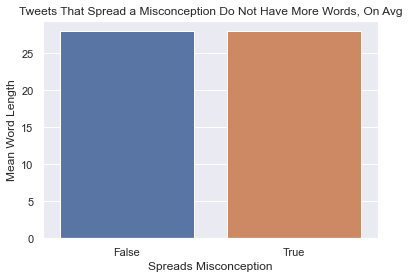

In [23]:
length_by_label = pd.DataFrame(clean_unique.groupby('misconception').tweet_len.mean().rename('mean_length')).reset_index()

plot = sns.barplot(x='misconception', y='mean_length', data =length_by_label)
plot.set(title = 'Tweets That Spread a Misconception Do Not Have More Words, On Avg', 
         xlabel='Spreads Misconception', ylabel='Mean Word Length')